<a href="https://colab.research.google.com/github/delalamo/dda_docs/blob/main/DEERNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import skewnorm, cauchy, t

We will first need to define a few constants for our functions. These include then minima, maxima, and scaling factors dictating whether values tend to be bunched to lower or higher values (high scaling factors lead to bunching at lower values).

In [3]:
MEAN_LO = 15.
MEAN_HI = 70.
MEAN_SCALE = 4

STDEV_LO = 0.5
STDEV_HI = 15.
STDEV_SCALE = 10

SKEW_LO = 0.
SKEW_HI = 10.
SKEW_SCALE = 4

DIST_MIN = 10.
DIST_MAX = 80.
DIST_STEP = 0.1

def rand_u():
  #==============
  r"""Return a random mean variable given the constants outlined above

  Parameters:
  None

  Returns:
  float

  Notes:
  The scale is to skew values toward shorter distances.
  In practice longer DEER distances are not ideal.
  """
  return np.random.uniform(
      low  = MEAN_LO ** ( 1. / MEAN_SCALE ),
      high = MEAN_HI ** ( 1. / MEAN_SCALE ) ) ** MEAN_SCALE 

def rand_s():
  #==============
  r"""Return a random standard deviation variable given constants outlined above

  Parameters:
  None

  Returns:
  float

  Notes:
  The scale is to skew values toward sharper distance values.
  In practice, very broad distributions are not prefered (and not encountered)
  """
  return np.random.uniform(
      low  = STDEV_LO ** ( 1. / STDEV_SCALE ),
      high = STDEV_HI ** ( 1. / STDEV_SCALE ) ) ** STDEV_SCALE 

def rand_skew():
  #==============
  r"""Return a random skew variable given constants outlined above

  Parameters:
  None

  Returns:
  float

  Notes:
  Skewed distributions are not usually experimentally encountered.
  However, it is unclear if this is because they are rare,
      or because the analytical methods in widespread use cannot obtain them.
  Therefore, we are adding some skewed distributions; however, they constitute the minority
  """
  return random.choice( range( -1, 2 ) ) * np.random.uniform(
      low  = SKEW_LO ** ( 1. / SKEW_SCALE ),
      high = SKEW_HI ** ( 1. / SKEW_SCALE ) ) ** SKEW_SCALE 

In [4]:
def new_distr( u, s, amp, skew=0, df=0, rmin=10., rmax=80., step=0.1 ):
    #==============
    r"""Simulate a skewed Gaussian/normal distribution
    
    Parameters:
    u    : Mean (in Angstroms)
    s    : Standard deviation (in Angstroms)
    amp  : Amplitude of the peak
    skew : Skew, ranges from -inf to inf, with zero=no skew
    rmin : Lowest distance value (in Angstroms)
    rmax : Highest distance value (in Angstroms)
    step : Step size for distance distribution (in Angstroms)
    
    Returns:
    np.array (1D) of amplitudes; no actual distance data is provided
    The distance data must be inferred from the provided rmin and rmax
    
    Notes:
    Unfortunately Scipy uses "t" for student's t distribution.
    This means we cannot use the variable t throughout this notebook.
    """
    bins = np.array([ ( r - u ) / s for r in np.arange( rmin, rmax, step ) ])
    return random.choice( [
        [ amp * skewnorm.pdf( b, skew ) for b in bins ],
        [ amp * cauchy.pdf( b ) for b in bins ],
        [ amp * t.pdf( b, df ) for b in bins ]
    ] )

def rand_distr( rmin=10., rmax=80., step=0.1, nmin=1, nmax=3 ):
  #==============
  r"""Generate a random distribution

  Parameters:
  rmin : Minimum distance (in Angstroms)
  rmax : Maximum distance (in Angstroms)
  nmin : Minimum number of components
  nmax : Maximum number of components
  """    
  output = np.zeros( ( len( np.arange( rmin, rmax, step ) ) ) )
  n = np.random.uniform( 0.1, 1.0, random.randint( nmin, nmax ) )
  n /= n.sum()
  for amp in n:
      output += new_distr(
          u=rand_u(),
          s=rand_s(),
          amp=amp,
          skew=rand_skew(),
          df=random.randint( 1, 10 ),
          rmin=DIST_MIN,
          rmax=DIST_MAX,
          step=DIST_STEP
      )
  return output / sum( output )


Here are a few examples of these distance data

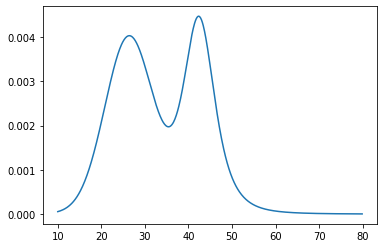

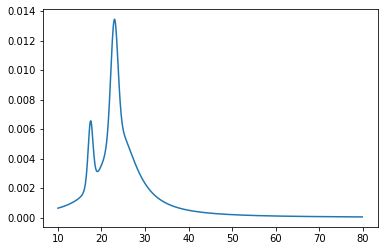

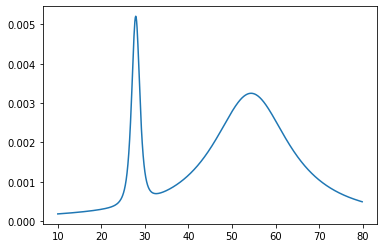

In [5]:
for i in range( 3 ):
  distr = rand_distr()
  plt.plot( np.arange( DIST_MIN, DIST_MAX, DIST_STEP ), distr )
  plt.show()

Next we need to convert these data into DEER traces in the time domain. First we simulate the signal from the distance data, then we add in the background DEER signal.

In [6]:
# These are the angle-dependent coupling parameters
# See Jeschke 2012 Annu. Rev. Phys. Chem. 2012 for details
angle_bins = np.arange( 0., np.pi / 2., 0.02)
deer_bins = 1. -3. * ( np.cos( angle_bins ) ** 2 )

def dipolar_kernel( rd, tp ):
  #==============
  r"""Determines the intramolecular dipolar coupling intensity for
      a given distance (in Angstroms) at a given time point (in microseconds)

  Parameters:
  rd : Distance (in Angstroms; float)
  tp : Time point (in microseconds; float)

  Returns:
  float

  Notes:
  None
  """    
  if rd < 15.: # HARD CUTOFF DUE TO DIPOLAR J-COUPLING
      return 0.0
  vc = np.zeros( len( deer_bins ) ) + ( 326.98 * tp / ( ( rd / 10. ) ** 3. ) )
  vc = np.sin( angle_bins ) * np.cos( vc * deer_bins )
  return np.sum( vc )

In [7]:
def convert_to_decay( distr, time_pts, dist_bins ):
  #==============
  r"""Converts a distance distribution into a DEER signal the time domain

  Parameters:
  distr     : Distance distribution amplitudes (np.array)
  time_pts  : Time points (np.array)
  dist_bins : Distance bins corresponding to distr array (np.array)

  Returns:
  np.array (1D) of normalized values corresponding to DEER trace

  Notes:
  The trace is normalized such that V(t=0)=1
  """    
  output = np.zeros( len( time_pts ) )
  for i, tp in enumerate( time_pts ):
      for amp, rd in zip( distr, np.arange( DIST_MIN, DIST_MAX, DIST_STEP ) ):
          output[ i ] += amp * dipolar_kernel( rd, tp )
  return output / output.max()

Let's test out some of these functions really quickly.

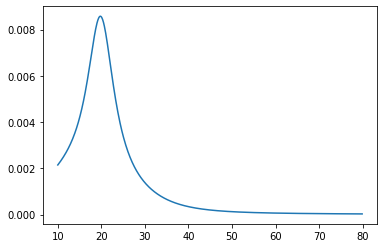

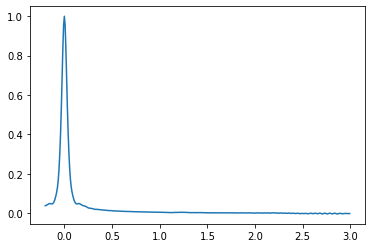

In [9]:
bins = np.arange( 10., 80., 0.1 )
distr = rand_distr()
plt.plot( bins , distr )
plt.show()

time_pts = np.arange( -0.2, 3.0, 0.008 )
trace = convert_to_decay( distr, time_pts, bins )
plt.plot( time_pts, trace )
plt.show()

Looks pretty good. Now let us add the background component and a little bit of Gaussian noise.

In [20]:
def intra( tr, tp, d, k, l ):
  return np.exp((np.abs(tp)*k)**(d/3.))*(1.-l*(1.-tr))

def add_bckg( trace, tpts ):
  d = 3. + ( np.random.uniform( -1., 0.5 ) * random.choice( [ 0., 1. ] ) )
  k = -1. * np.random.uniform( 10 ** -6., 10 ** -0.5 )
  l = np.random.uniform( 0.05, 0.7 )
  return np.array( [ intra( tr, tp, d, k, l ) for tr, tp in zip( trace, tpts ) ] )

def add_noise( trace ):
  n = np.random.uniform( 0.005**(1./5.), 0.1**(1./5.) )**5.
  return trace + np.random.normal( 0., n, len( trace ) )

def normalize( trace ):
  return trace / max( trace )

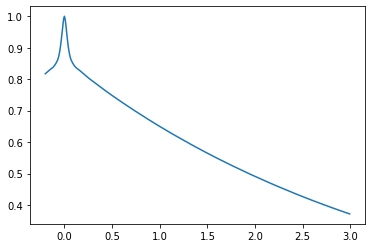

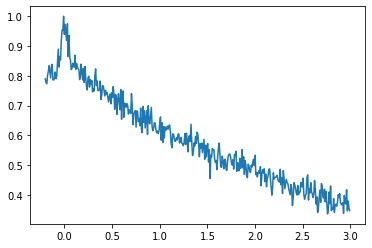

In [26]:
bckg_trace = add_bckg( trace, time_pts )
plt.plot( time_pts, bckg_trace )
plt.show()
noisy_trace = normalize( add_noise( bckg_trace ) )
plt.plot( time_pts, noisy_trace )
plt.show()

Unfortunately, since the process for simulating DEER decay traces from distance data takes so long, I went ahead and wrote a small program in C++ that does this. All distance data are simulated here and converted to decay traces in that program. The distance data will be the "target" and the decay data will be the input. I went ahead and simulated a few distance distributions for test purposes.

In [59]:
n_distrs = 10
df = pd.DataFrame()
for i in range( n_distrs ):
  distr = rand_distr()
  df = pd.concat( [ df, pd.DataFrame( distr.reshape( -1, len( distr ) ) ) ] )
print( df.shape )
df.to_csv( "distributions.csv" )

(10, 700)
